In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
    
print(tf.__version__)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:

fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)


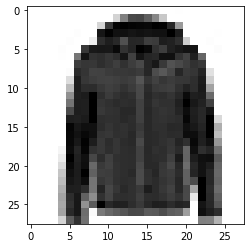

In [3]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap='binary')
    plt.show()
    
show_single_image(x_train[0])

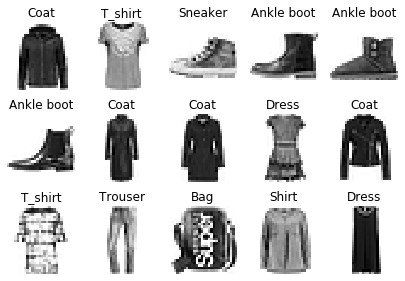

In [4]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(x_data[index], cmap='binary', interpolation = 'nearest')
            
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = ['T_shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

Relu: 
$$y = max(0, x)$$
Softmax:
$$x = [x1, x2, x3]$$
$$y = [\frac{e^x1}{sum}, \frac{e^x2}{sum}, \frac{e^x3}{sum}]$$
$$sum = e^x1 + e^x2 + e^x3$$

In [13]:
# x = (x-u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                             padding='same',
                             activation='relu',
                             input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                             padding='same',
                             activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                             padding='same',
                             activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                             padding='same',
                             activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                             padding='same',
                             activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                             padding='same',
                             activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))


# reason for sparse: y is index use sparse, y is one_hot vector use categorical_crossentropy
model.compile(loss='sparse_categorical_crossentropy',
             optimiser='sgd',
             metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)        

In [16]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]


history = model.fit(x_train_scaled, y_train, epochs=10,
                   validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 353s 6ms/sample - loss: 0.4216 - accuracy: 0.8479 - val_loss: 0.2756 - val_accuracy: 0.8986
Epoch 2/10
55000/55000 [==============================] - 297s 5ms/sample - loss: 0.2613 - accuracy: 0.9075 - val_loss: 0.2308 - val_accuracy: 0.9170
Epoch 3/10
55000/55000 [==============================] - 300s 5ms/sample - loss: 0.2311 - accuracy: 0.9179 - val_loss: 0.2452 - val_accuracy: 0.9126
Epoch 4/10
55000/55000 [==============================] - 284s 5ms/sample - loss: 0.2262 - accuracy: 0.9215 - val_loss: 0.2410 - val_accuracy: 0.9212
Epoch 5/10
55000/55000 [==============================] - 272s 5ms/sample - loss: 0.2292 - accuracy: 0.9247 - val_loss: 0.2399 - val_accuracy: 0.9142
Epoch 6/10
55000/55000 [==============================] - 316s 6ms/sample - loss: 0.3259 - accuracy: 0.9239 - val_loss: 0.3000 - val_accuracy: 0.9148
Epoch 7/10
55000/55000 [===========================

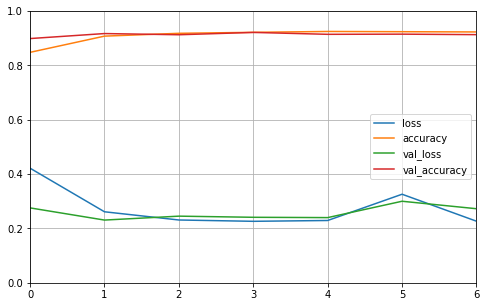

In [18]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)